# PHATE visualization of ECT pavement cell images

### Import necessary modules

In [1]:
import os # for dealing with directories
from os import listdir # for retrieving files from directory
from os.path import isfile, join # for retrieving files from directory
import pandas as pd # for working with dataframes
import numpy as np # for arrays
from ect import ECT, EmbeddedGraph # for calculating ECTs
from scipy.spatial import ConvexHull # for convex hull
from sklearn.decomposition import PCA # for PCA for normalization
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting
import phate # for using PHATE 
import scprep # for using PHATE

### Functions

In [2]:
def poly_area(x,y):
    """
    define a function to calculate the area of a polygon using the shoelace algorithm
    inputs: separate numpy arrays of x and y coordinate values
    outputs: the area of the polygon
    """
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

Data is from [Modified leaf shape contour data](https://figshare.com/articles/dataset/Modified_leaf_shape_contour_data/25435936) (Wang, Willey, and Chitwood, 2024). All folders together are 1.19 GB compressed. Download and unzip all folders and save in a folder named `2017_leaves`.

### Save ECT files for pavement cells

Save ECT images for pavement cells.

<div class="alert alert-block alert-warning"">
<b>Careful:</b> This takes ~50 minutes to run. Do not execute if you have already saved ECT images to file.
</div>

The following pavement cell shapes collected from across plants is from the following publication:

Róza V. Vőfély, Joseph Gallagher, Grace D. Pisano, Madelaine Bartlett, Siobhan A. Braybrook (2019) [**Of puzzles and pavements: a quantitative exploration of leaf epidermal cell shape**](https://doi.org/10.1111/nph.15461), *New Phytologist* 221(1):540-552.

The data is available on [Dryad](https://datadryad.org/stash/dataset/doi:10.5061/dryad.g4q6pv3). In order to run the code below, you will need to download the cell outlines stored as `.txt` files in the `CellCoordinates.zip` folder (19.61MB). Please use the `SampleTable.csv` file in this GitHub repo, with sample names used to generate paths to pavement cell shapes and associated metadata, to execute the code below.

Read in the sample table dataframe

In [10]:
cell_df = pd.read_csv("./SampleTable.csv", encoding='unicode_escape')

cell_df.drop(cell_df[cell_df["Sample_Number"]=="gp15-104-22"].index, inplace=True) # drop sample
cell_df.drop(cell_df[cell_df["Sample_Number"]=="JH15-010-ad-6"].index, inplace=True) # drop sample

Create a folder to save the ECT images if it doesn't already exist named `ect_cell_files`.

In [12]:
path = "ect_cell_files"
# Check whether the specified path exists or not
isExist = os.path.exists(path)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(path)
   print("The new directory is created!")

Save the ECT images to the folder. They will use the same file name as in `cell_df` and be saved as `.npy` files.

In [ ]:
num_dir=70 # set number of directional axes
num_thresh=70 # set number of thresholds each axis

for i in range(len(cell_df)): # for each leaf

    shape = np.loadtxt("./CellCoordinates/"+str(cell_df["Sample_Number"].iloc[i])+".txt",skiprows=1) # get the current shape

    if i%1000==0:
        print(i)

    G = EmbeddedGraph() # initiate a graph
    G.add_cycle(shape) # create graph from shape
    G.set_PCA_coordinates( center_type='min_max', scale_radius=1) # perform PCA and normalize
    myect = ECT(num_dirs = num_dir, num_thresh=num_thresh) # calculate ECT
    myect.set_bounding_radius(1) # set bounding radius
    M = myect.calculateECT(G) # retrieve ECT

    np.save("./ect_cell_files/"+str(cell_df["Sample_Number"].iloc[i])+".npy", M) # save ECT file


### Create an ECT pavement cell array

Read back in saved ECT `.npy` files and save as an array. 

<div class="alert alert-block alert-warning"">
<b>Careful:</b> It takes ~11 seconds to read in all the leaf ECT images.
</div>

Get the ECT image file names

In [46]:
data_dir = "./ECT_cell_files/" # set data directory
files = [f for f in listdir(data_dir) if isfile(join(data_dir, f))] # create a list of file names
#files.remove('.DS_Store') # remove .DS_Store file
files.sort() # sort the list of file names

Create the ECT cell array and save index and dataset information.

In [54]:
ect_cell_arr = np.zeros((len(files),70,70)) # create an array to save ECT images
sample_num_cell = [] # a list to store sample numbers
dataset_cell = [] # a list to store dataset info

for i in range(len(files)): # for each file

    if i%1000==0: # print every 1000
        print(i)
    
    curr_cell = files[i] # get current file name
    sample_num_cell.append(curr_cell[:-4]) # get sample number for path 
    dataset_cell.append(cell_df["Major Clade"][cell_df["Sample_Number"]==curr_cell[:curr_cell.index(".npy")]].item()) # get dataset info

    ect_cell_arr[i,:,:] = np.load("./ect_cell_files/"+curr_cell) # load and save cell ECT to array


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000


### Calculate width-to-length ratio and solidity

<div class="alert alert-block alert-warning"">
<b>Careful:</b> It takes ~10 seconds to calculate solidity and aspect ratio. If saved already, read in the file cell_data.csv instead
</div>

In [55]:
solidity8 = [] # store solidity values
wl_ratio = [] # store width-to-length ratio values

for i in range(len(sample_num_cell)): # for each pavement cell in ECT array

    if i%1000==0:
        print(i)
    
    sam_num = int(ind_cell[i]) # get the sample for current cell
    curr_file = sample_num_cell[i] + ".txt" # get file path

    # load in file
    shape = np.loadtxt("./CellCoordinates/"+curr_file, skiprows=1)
     
    # calculate solidity
    hull = ConvexHull(shape) # calculate convex hull of current shape
    vertices = hull.vertices # isolate vertex indices of convex hull
    area = poly_area(shape[:,0], shape[:,1]) # calculate area
    convex_area = poly_area(shape[vertices,0], shape[vertices,1]) # calculate convex area
    solidity8.append( (area / convex_area)**8 ) # calculate solidity**8 and store

    # calculate length-to-width ratio
    pca = PCA(n_components=2) # initiate PCA
    pca.fit_transform(shape) # fit PCA to shape data to find longest axis
    pca_scores = pca.transform(shape) # retrieve PCA scores of shape
    length = np.max(pca_scores[:,0])-np.min(pca_scores[:,0]) # get length
    width = np.max(pca_scores[:,1])-np.min(pca_scores[:,1]) # get width
    wl_ratio.append(width/length) # store length-to-width ratio

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000


In [56]:
# create the dataframe
df = pd.DataFrame({
    "solidity8":solidity8,
    "wl_ratio":wl_ratio,
    "group":dataset_cell,
    "sample_number":sample_num_cell})

# save the dataframe to file
df.to_csv("cell_data.csv")

### PHATE - Potential of Heat-diffusion for Affinity-based Trajectory Embedding
<div class="alert alert-block alert-warning"">
<b>Careful:</b> It takes ~2 minutes to calculate PHATE. If already run, load in the PHATE scores below.
</div>

In [57]:
# read in the metadata
df = pd.read_csv("./cell_data.csv")

# check the df
df.head()

,Unnamed: 0,solidity8,wl_ratio,group,sample_number
0,0,0.350605,0.366506,monocots,3.01.1.1
1,1,0.379707,0.160133,monocots,3.01.1.10
2,2,0.379518,0.158126,monocots,3.01.1.11
3,3,0.260559,0.203026,monocots,3.01.1.12
4,4,0.419024,0.398826,monocots,3.01.1.13


Peform PHATE. Note: default settings (which should be used for final figures) take about an hour to run.

For a faster run (with minimal effects on final output) that takes about 2 minutes, use the following arguments:

```python
phate_operator = phate.PHATE(n_components=3,
                                     knn=5,
                                     knn_max=25, # For speed
                                     knn_dist="euclidean",
                                     mds_dist="euclidean",
                                     mds="metric",
                                     mds_solver="sgd",
                                     n_jobs=-2, # For speed
                                     n_pca=20, # For speed
                                     random_state=42,
                                     )
```

In [58]:
# create a flat array
flat_arr = np.reshape(ect_cell_arr, (np.shape(ect_cell_arr)[0],
                                    np.shape(ect_cell_arr)[1]*np.shape(ect_cell_arr)[2]))

# create the PHATE embedding and transform
phate_operator = phate.PHATE(n_components=3,random_state=42)
phate_cell = phate_operator.fit_transform(flat_arr)

Calculating PHATE...
  Running PHATE on 11346 observations and 4900 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 10.62 seconds.
    Calculating KNN search...
    Calculated KNN search in 6.40 seconds.
    Calculating affinities...
    Calculated affinities in 0.08 seconds.
  Calculated graph and diffusion operator in 17.11 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.51 seconds.
    Calculating KMeans...
    Calculated KMeans in 2.45 seconds.
  Calculated landmark operator in 3.34 seconds.
  Calculating optimal t...
    Automatically selected t = 22
  Calculated optimal t in 1.96 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.81 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 58.18 seconds.
Calculated PHATE in 81.42 seconds.


Save the output

In [59]:
np.save("phate_scores_cells.npy", phate_cell)

### Visualization

Load in the PHATE scores

In [66]:
phate_fast = np.load("./phate_scores_cells.npy")
np.shape(phate_fast)

(11346, 3)

Load in the associated metadata

In [67]:
df = pd.read_csv("./cell_data.csv")

Add PHATE scores to dataframe

In [68]:
df["phate1"] = phate_fast[:,0]
df["phate2"] = phate_fast[:,1]
df["phate3"] = phate_fast[:,2]

In [69]:
df["group"].unique()

array(['monocots', 'eudicots', 'ferns', 'gymnosperms',
       'early_diverging_angiosperms'], dtype=object)

Create color palette

In [126]:
# create dictionary color palette
pal = {
    "monocots":"#1b9e77",
    "eudicots":"#d95f02",
    "ferns":"#7570b3",
    "gymnosperms":"#e7298a",
    "early_diverging_angiosperms":"gold"}


Find cell shape indices to visualize

In [127]:
# number of intervals across phate axes
num_ph1_int = 20
num_ph2_int = 20
num_ph3_int = 10

# create intervals across PHATE values
ph1_vals = np.linspace(np.min(df["phate1"]),np.max(df["phate1"]),num_ph1_int)
ph2_vals = np.linspace(np.min(df["phate2"]),np.max(df["phate2"]),num_ph2_int)
ph3_vals = np.linspace(np.min(df["phate3"]),np.max(df["phate3"]),num_ph3_int)

# store indices of leaves to analyze PHATE 1 & 2
lf_inds_12 = []

# store indices of leaves to analyze PHATE 1 & 3
lf_inds_13 = []

# store indices of leaves to analyze PHATE 2 & 3
lf_inds_23 = []

# select PHATE 1 & 2 leaves
for i in range(len(ph1_vals)-1): # for the PHATE 1 vals
    for j in range(len(ph2_vals)-1): # for the PHATE 2 vals
        # create df of selected leaves
        select_df = df[((df["phate1"]>=ph1_vals[i])&(df["phate1"]<=ph1_vals[i+1])) & 
                       ((df["phate2"]>=ph2_vals[j])&(df["phate2"]<=ph2_vals[j+1]))]
        if len(select_df)==0: # continue if no leaves
            continue
        else: # else save the index of one leaf
            lf_inds_12.append(select_df.sample(n=1,random_state=42).index[0])

# select PHATE 1 & 3 leaves
for i in range(len(ph1_vals)-1): # for the PHATE 1 vals
    for j in range(len(ph3_vals)-1): # for the PHATE 3 vals
        # create df of selected leaves
        select_df = df[((df["phate1"]>=ph1_vals[i])&(df["phate1"]<=ph1_vals[i+1])) & 
                       ((df["phate3"]>=ph3_vals[j])&(df["phate3"]<=ph3_vals[j+1]))]
        if len(select_df)==0: # continue if no leaves
            continue
        else: # else save the index of one leaf
            lf_inds_13.append(select_df.sample(n=1,random_state=42).index[0])

# select PHATE 2 & 3 leaves
for i in range(len(ph2_vals)-1): # for the PHATE 2 vals
    for j in range(len(ph3_vals)-1): # for the PHATE 3 vals
        # create df of selected leaves
        select_df = df[((df["phate2"]>=ph2_vals[i])&(df["phate2"]<=ph2_vals[i+1])) & 
                       ((df["phate3"]>=ph3_vals[j])&(df["phate3"]<=ph3_vals[j+1]))]
        if len(select_df)==0: # continue if no leaves
            continue
        else: # else save the index of one leaf
            lf_inds_23.append(select_df.sample(n=1,random_state=42).index[0])
        


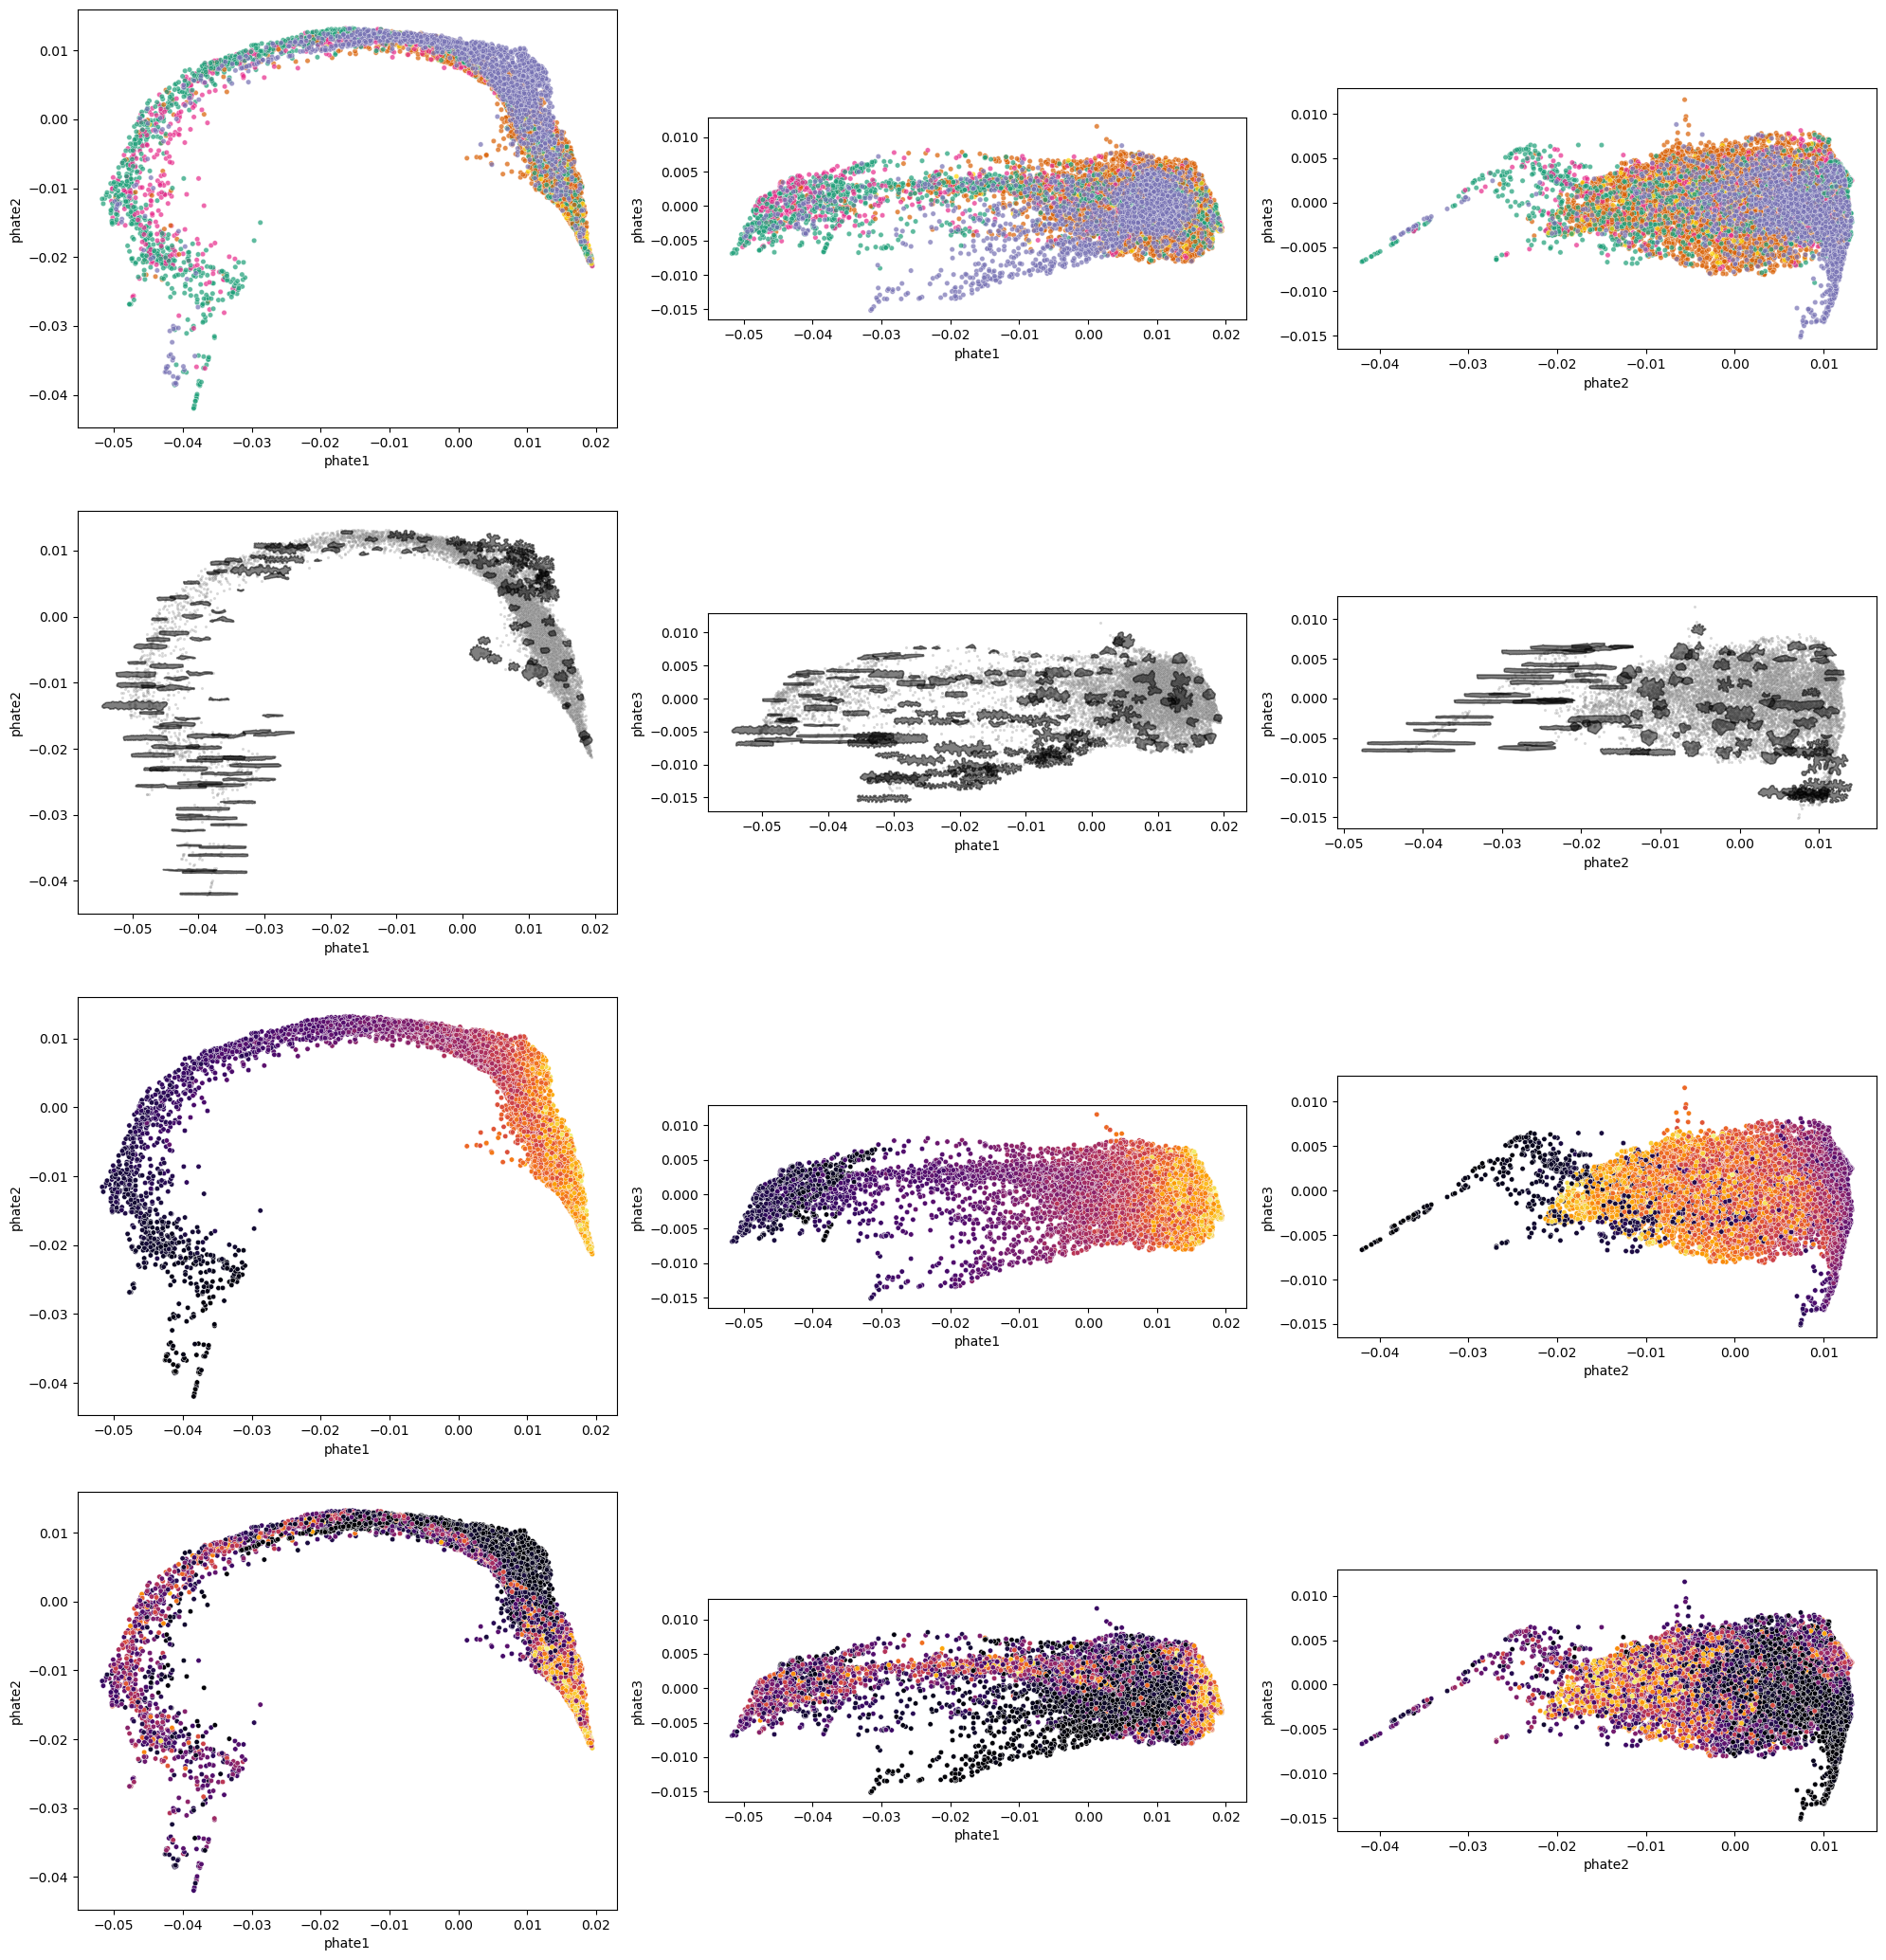

In [133]:
plt.figure(figsize=(20,21))

##############
### groups ###
##############

plt.subplot(4,3,1)
sns.scatterplot(data=df, x="phate1", y="phate2", s=15, legend=False, hue="group", palette=pal, alpha=0.7)
plt.gca().set_aspect("equal")

plt.subplot(4,3,2)
sns.scatterplot(data=df, x="phate1", y="phate3", s=15, legend=False, hue="group", palette=pal, alpha=0.7)
plt.gca().set_aspect("equal")

plt.subplot(4,3,3)
sns.scatterplot(data=df, x="phate2", y="phate3", s=15, legend=False, hue="group", palette=pal, alpha=0.7)
plt.gca().set_aspect("equal")

##############
### shapes ###
##############

scale = 0.00001
a = 0.5

plt.subplot(4,3,4)
sns.scatterplot(data=df, x="phate1", y="phate2", s=5, alpha=0.3, c="gray")
plt.gca().set_aspect("equal")
for i in range(len(lf_inds_12)):
    plt.subplot(4,3,4)
    curr_lf = df["sample_number"].iloc[lf_inds_12[i]]
    shape = np.loadtxt("./CellCoordinates/"+curr_lf+".txt", skiprows=1)
    pca = PCA(n_components=2) # initiate PCA
    pca.fit_transform(shape) # fit PCA to shape data to find longest axis
    pca_scores = pca.transform(shape) # retrieve PCA scores of shape
    plt.fill(pca_scores[:,0]*scale+df["phate1"].iloc[lf_inds_12[i]],
             pca_scores[:,1]*scale+df["phate2"].iloc[lf_inds_12[i]],
             c="k", alpha=a)
    plt.gca().set_aspect("equal")

plt.subplot(4,3,5)
sns.scatterplot(data=df, x="phate1", y="phate3", s=5, alpha=0.3, c="gray")
plt.gca().set_aspect("equal")
for i in range(len(lf_inds_13)):
    plt.subplot(4,3,5)
    curr_lf = df["sample_number"].iloc[lf_inds_13[i]]
    shape = np.loadtxt("./CellCoordinates/"+curr_lf+".txt", skiprows=1)
    pca = PCA(n_components=2) # initiate PCA
    pca.fit_transform(shape) # fit PCA to shape data to find longest axis
    pca_scores = pca.transform(shape) # retrieve PCA scores of shape
    plt.fill(pca_scores[:,0]*scale+df["phate1"].iloc[lf_inds_13[i]],
             pca_scores[:,1]*scale+df["phate3"].iloc[lf_inds_13[i]],
             c="k", alpha=a)
    plt.gca().set_aspect("equal")

plt.subplot(4,3,6)
sns.scatterplot(data=df, x="phate2", y="phate3", s=5, alpha=0.3, c="gray")
plt.gca().set_aspect("equal")
for i in range(len(lf_inds_23)):
    plt.subplot(4,3,6)
    curr_lf = df["sample_number"].iloc[lf_inds_23[i]]
    shape = np.loadtxt("./CellCoordinates/"+curr_lf+".txt", skiprows=1)
    pca = PCA(n_components=2) # initiate PCA
    pca.fit_transform(shape) # fit PCA to shape data to find longest axis
    pca_scores = pca.transform(shape) # retrieve PCA scores of shape
    plt.fill(pca_scores[:,0]*scale+df["phate2"].iloc[lf_inds_23[i]],
             pca_scores[:,1]*scale+df["phate3"].iloc[lf_inds_23[i]],
             c="k", alpha=a)
    plt.gca().set_aspect("equal")
    

#############################
### width-to-length ratio ###
#############################

plt.subplot(4,3,7)
sns.scatterplot(data=df, x="phate1", y="phate2", hue="wl_ratio", s=15, legend=False, palette="inferno")
plt.gca().set_aspect("equal")

plt.subplot(4,3,8)
sns.scatterplot(data=df, x="phate1", y="phate3", hue="wl_ratio", s=15, legend=False, palette="inferno")
plt.gca().set_aspect("equal")

plt.subplot(4,3,9)
sns.scatterplot(data=df, x="phate2", y="phate3", hue="wl_ratio", s=15, legend=False, palette="inferno")
plt.gca().set_aspect("equal")

################
### solidity ###
################

plt.subplot(4,3,10)
sns.scatterplot(data=df, x="phate1", y="phate2", hue="solidity8", s=15, legend=False, palette="inferno")
plt.gca().set_aspect("equal")

plt.subplot(4,3,11)
sns.scatterplot(data=df, x="phate1", y="phate3", hue="solidity8", s=15, legend=False, palette="inferno")
plt.gca().set_aspect("equal")

plt.subplot(4,3,12)
sns.scatterplot(data=df, x="phate2", y="phate3", hue="solidity8", s=15, legend=False, palette="inferno")
plt.gca().set_aspect("equal")

plt.tight_layout()


Create legend for groups

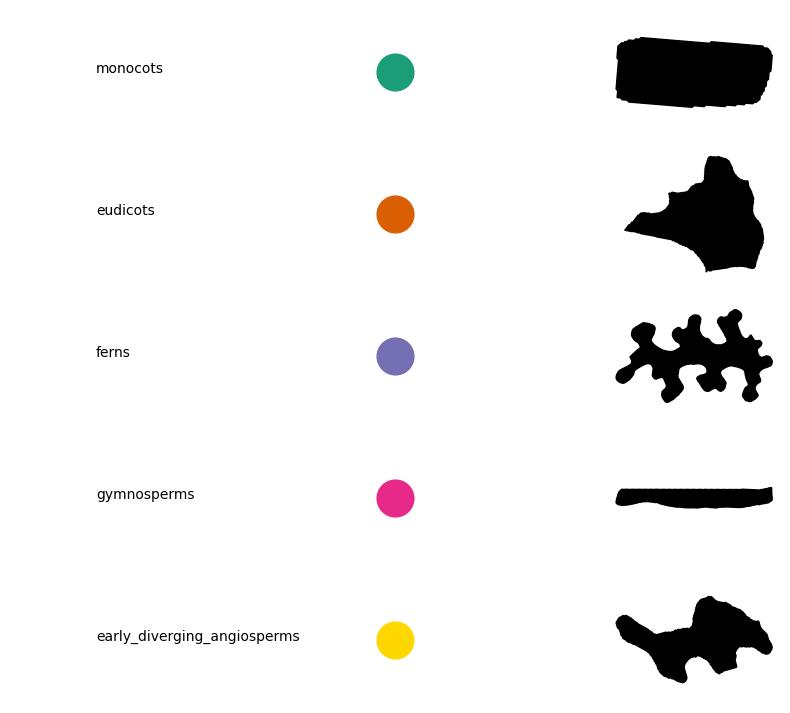

In [134]:
names = df["group"].unique()
counter=1

plt.figure(figsize=(8,20))

for i in range(len(names)):

    plt.subplot(14,3,counter)
    plt.text(0.5,0.5,names[i], fontsize=10)
    plt.axis("off")
    counter+=1
    
    plt.subplot(14,3,counter)
    plt.scatter(0,0,c=pal[names[i]],s=700)
    plt.axis("off")
    counter+=1
    
    plt.subplot(14,3,counter)
    lf = df["sample_number"][df["group"]==names[i]].sample(n=1, random_state=4).item()
    shape = np.loadtxt("./CellCoordinates/"+lf+".txt", skiprows=1)
    pca = PCA(n_components=2) # initiate PCA
    pca.fit_transform(shape) # fit PCA to shape data to find longest axis
    pca_scores = pca.transform(shape) # retrieve PCA scores of shape
    plt.fill(pca_scores[:,0], pca_scores[:,1], c="k")
    plt.gca().set_aspect("equal")
    plt.axis("off")
    counter+=1
    
plt.tight_layout()

Create legend for width-to-length ratio

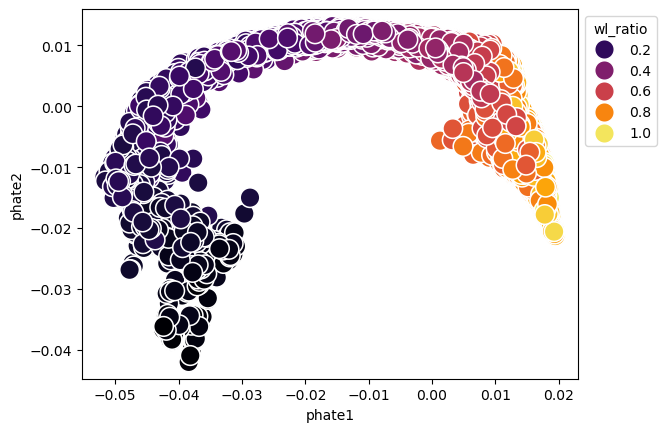

In [103]:
ax = sns.scatterplot(data=df, x="phate1", y="phate2", hue="wl_ratio", s=200, legend=True, palette="inferno")
sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1, 1))

Create legend for solidity

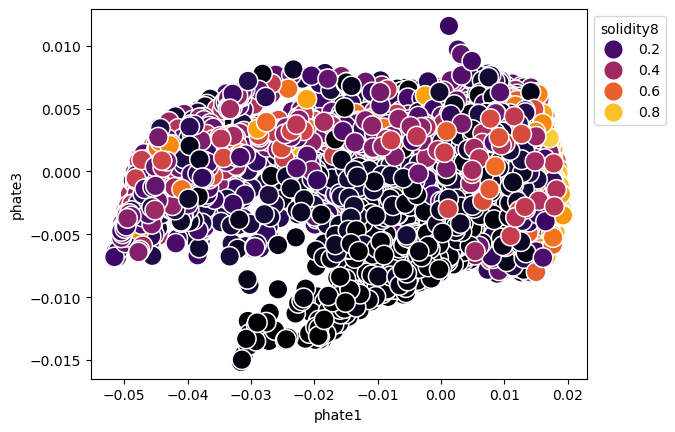

In [104]:
ax = sns.scatterplot(data=df, x="phate1", y="phate3", hue="solidity8", s=200, legend=True, palette="inferno")
sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1, 1))